# Sensitivity analysis of the critical head difference

In this example, we will demonstrate how to conduct a sensitivity analysis of the critical head difference model developed by Sellmeijer. This model is applicable to the piping failure mechanism, which addresses backward internal erosion beneath dikes with predominantly horizontal seepage paths.

### Define model

First, let's import the necessary packages:

In [85]:
from probabilistic_library import SensitivityProject, DistributionType, SensitivityMethod
import numpy as np
import matplotlib.pyplot as plt

The critical head difference, $H_c$, according to the Sellmeijer's model is described by the following equations:

$F_{resistance}=\eta\cdot \frac{\gamma_{sub,particles}}{\gamma_{water}}\cdot \tan \theta_{sellmeijer,rev}$


$F_{scale}=\frac{d_{70.m}}{\sqrt[3]{\kappa\cdot L}}\cdot\left(\frac{d_{70}}{d_{70.m}}\right)^{0.4}$ and $\kappa = \frac{\nu_{water}}{g}\cdot k$


$F_{geometry}=0.91\cdot \left(\frac{D}{L}\right)^{\frac{0.28}{\left(\frac{D}{L}\right)^{2.8}-1}+0.04}$

$H_c = F_{resistance} \cdot F_{scale} \cdot F_{geometry} \cdot L$

where: <br>
$L$ - seepage length (m) <br>
$D$ - thickness of upper sand layer (m) <br>
$\theta$ - bedding angle ($\circ$) <br>
$d_{70}$ - particle diameter (m) <br>
$k$ - permeability of the upper sand layer (m/s)

In [86]:
from utils.models import model_sellmeijer
label_critical_head_diff = "critical head difference (m)"
label_pdf = "pdf (-)"

### Sensitivity analysis

The goal is to estimate the effect of the input parameters $k$, $L$, $d_{70}$ and $D$ on the critical head difference. 
To achieve this, we conduct a sensitivity analysis, we begin by creating a sensitivity project and defining the model:

In [87]:
project = SensitivityProject()
project.model = model_sellmeijer

from utils.printing import print_input_output_var
print_input_output_var(project.model)

Input parameters:
k
L
d70
D

Output parameters:
delta_h_c


We define all the input parameters of the model as deterministic variables:

In [88]:
project.variables["k"].distribution = DistributionType.deterministic
project.variables["k"].mean = 0.000245598

project.variables["L"].distribution = DistributionType.deterministic
project.variables["L"].mean = 40.0

project.variables["d70"].distribution = DistributionType.deterministic
project.variables["d70"].mean = 0.00019

project.variables["D"].distribution = DistributionType.deterministic
project.variables["D"].mean = 30.0

### Crude Monte Carlo

The following code estimates the effect of each parameter on the critical head difference. Each parameter is assumed to follow a log-normal distribution, with the mean value as specified above and a standard deviation equal to 25% of the mean.

We use the `crude_monte_carlo` method and define the relevant settings: `minimum_samples` and `maximum_samples`.

The sensitivity analysis is performed using `project.run()`, and the results can be accessed from `project.stochast`.

In [89]:
project.settings.sensitivity_method = SensitivityMethod.crude_monte_carlo
project.settings.minimum_samples = 100
project.settings.maximum_samples = 200

for var in ["k", "L", "d70", "D"]:
        
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
    
        project.run()
        sens = project.stochast
        
        print(f"Effect of {var}:( mean = {sens.mean}, std = {sens.deviation}, median = {sens.get_quantile(0.5)} )")
        
        project.variables[var].distribution = DistributionType.deterministic

Effect of k:( mean = 2.4019276265421916, std = 0.1945347947786058, median = 2.3877313179773205 )
Effect of L:( mean = 2.321004963350937, std = 0.4642433287202371, median = 2.2626004859523516 )
Effect of d70:( mean = 2.329505145238177, std = 0.23575661470502998, median = 2.29532402478645 )
Effect of D:( mean = 2.384997868315509, std = 0.08490030120560915, median = 2.3692996588643958 )


The results of the sensitivity analysis with `crude_monte_carlo` are presented in a `histogram`, which can be accessed as follows:

In [90]:
bin_start = [sens.histogram_values[ii].lower_bound for ii in range(0, len(sens.histogram_values))]
bin_end = [sens.histogram_values[ii].upper_bound for ii in range(0, len(sens.histogram_values))]
amount = [sens.histogram_values[ii].amount for ii in range(0, len(sens.histogram_values))]

We can also derive the corresponding probability density function using the `get_pdf()` method.

Text(0.5, 1.0, 'crude_monte_carlo')

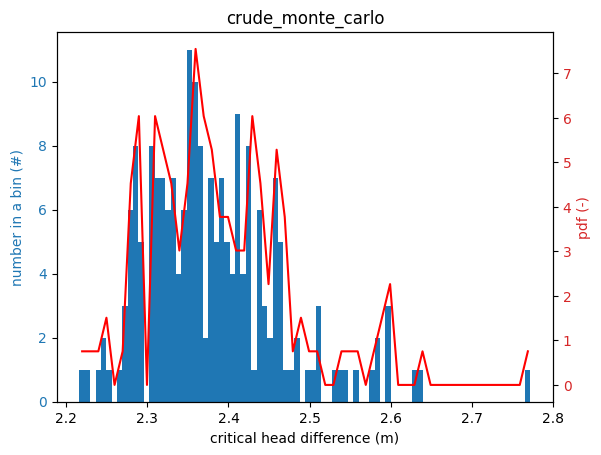

In [91]:
pdf_grid = np.arange(min(bin_start), max(bin_end), 0.01)
pdf = [sens.get_pdf(val) for val in pdf_grid]

fig, ax1 = plt.subplots()
color = "tab:blue"
ax1.set_xlabel(label_critical_head_diff)
ax1.set_ylabel("number in a bin (#)", color=color)
ax1.bar(bin_start, amount, width=(np.array(bin_end)-np.array(bin_start)), label=var)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel(label_pdf, color=color)
ax2.plot(pdf_grid, pdf, "r", label="pdf")
ax2.tick_params(axis="y", labelcolor=color)
plt.title(project.settings.sensitivity_method)

### Other methods

Other available sensitivity methods include: `numerical_integration`, `fosm`, `form`, `importance_sampling`, and `directional_sampling`.

The results from `numerical_integration` and `importance_sampling` are displayed in a `histogram`. The results from `form` and `directional_sampling` are displayed in a `cdf_curve`. The results from `fosm` follow a `normal` distribution. The distribution type can be checked with `sens.distribution`.

The following code demonstrates the sensitivity analysis using `fosm`.

In [92]:
project.settings.sensitivity_method = SensitivityMethod.fosm

for var in ["k", "L", "d70", "D"]:
                
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
        
        project.run()
        sens = project.stochast

        print(f"Effect of {var}:( mean = {sens.mean}, std = {sens.deviation}, median = {sens.get_quantile(0.5)} )")

        project.variables[var].distribution = DistributionType.deterministic

Effect of k:( mean = 2.3851618570590736, std = 0.20401638848709602, median = 2.3851618570590736 )
Effect of L:( mean = 2.30450201049311, std = 0.511695652618418, median = 2.30450201049311 )
Effect of d70:( mean = 2.333434185341425, std = 0.2351815920821294, median = 2.333434185341425 )
Effect of D:( mean = 2.3711273210279566, std = 0.09204013653525012, median = 2.3711273210279566 )


The following code demonstrates the sensitivity analysis using `form`.

Text(0.5, 1.0, 'form')

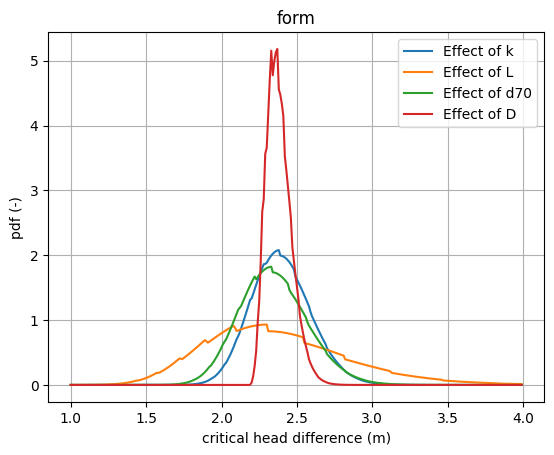

In [93]:
project.settings.sensitivity_method = SensitivityMethod.form

pdf_grid = np.arange(1.0, 4.0, 0.01)

plt.figure()
for var in ["k", "L", "d70", "D"]:
                
        project.variables[var].distribution = DistributionType.log_normal
        project.variables[var].deviation = project.variables[var].mean*0.25
        
        project.run()
        sens = project.stochast
        pdf = [sens.get_pdf(val) for val in pdf_grid]
        plt.plot(pdf_grid, pdf, label=f"Effect of {var}")
        project.variables[var].distribution = DistributionType.deterministic

plt.grid()
plt.xlabel(label_critical_head_diff)
plt.ylabel(label_pdf)
plt.legend()
plt.title(project.settings.sensitivity_method)

### Quantiles

It is also possible to derive quantiles from the resulting distribution function using `project.settings.quantiles`.

This functionality is demonstrated in the following example, where all input variables are considered to follow a `log_normal` distribution.

In [94]:
project.variables["k"].distribution = DistributionType.log_normal
project.variables["k"].deviation = project.variables["k"].mean*0.25

project.variables["L"].distribution = DistributionType.log_normal
project.variables["L"].deviation = project.variables["L"].mean*0.25

project.variables["d70"].distribution = DistributionType.log_normal
project.variables["d70"].deviation = project.variables["d70"].mean*0.25

project.variables["D"].distribution = DistributionType.log_normal
project.variables["D"].deviation = project.variables["D"].mean*0.25

We consider three quantiles: $5\%$, $50\%$, and $95\%$. And we run the sensitivity analysis.

In [95]:
quantiles = [0.05, 0.5, 0.95]
for q in quantiles:
    project.settings.quantiles.append(q)

project.run()
sens = project.stochast
results = project.results[0]

The resulting quantile values are stored in `project.results[0].quantile_realizations[ii].output_values[0]`:

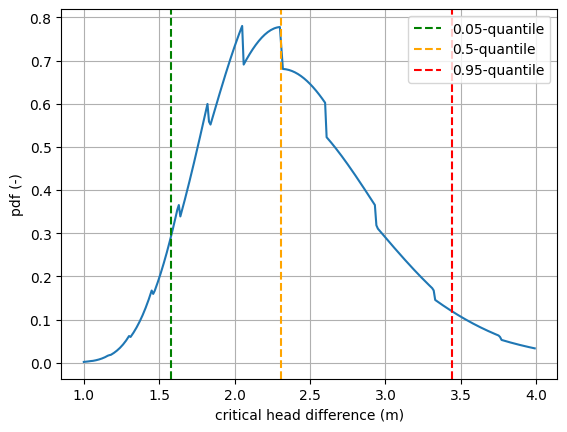

In [96]:
pdf_grid = np.arange(1.0, 4.0, 0.01)
col = ["green", "orange", "red"]
pdf = [sens.get_pdf(val) for val in pdf_grid]

plt.plot(pdf_grid, pdf)
for ii in range(len(results.quantile_realizations)):
    plt.axvline(x=results.quantile_realizations[ii].output_values[0], color=col[ii], linestyle="--", label=f"{quantiles[ii]}-quantile")
plt.grid()
plt.xlabel(label_critical_head_diff)
plt.ylabel(label_pdf)
plt.legend()

It is also possible to obtain the values of the input parameters that contribute the most to the quantile value. These values can be accessed via `project.results[0].quantile_realizations[ii].input_values[jj]`.

The values of the input parameters, when used in the model, must result in the corresponding quantile value.

In [97]:
for ii in range(len(results.quantile_realizations)):
    print(f"{quantiles[ii]}-quantile: {results.quantile_realizations[ii].output_values[0]}")

    for jj in range(len(project.model.input_parameters)):
        print(f"{project.model.input_parameters[jj].name}: {results.quantile_realizations[ii].input_values[jj]}")

    check_quantile = model_sellmeijer(results.quantile_realizations[ii].input_values[0],
                                      results.quantile_realizations[ii].input_values[1],
                                      results.quantile_realizations[ii].input_values[2],
                                      results.quantile_realizations[ii].input_values[3])
    
    print(f"Check quantile: {check_quantile}")

0.05-quantile: 1.5790818157751507
k: 0.0002741107363871163
L: 27.671767519838575
d70: 0.00015610560661370412
D: 30.57006870659653
Check quantile: 1.5790818157751507
0.5-quantile: 2.3099756378810685
k: 0.00023826505775069323
L: 38.80570000581328
d70: 0.00018432707502761308
D: 29.104275004359963
Check quantile: 2.3099756378810685
0.95-quantile: 3.4430976218147658
k: 0.00020810339231532862
L: 54.56556916278561
d70: 0.00021641537111617741
D: 27.36964145368886
Check quantile: 3.4430976218147658
